# Deep Learning for Pattern Prediction  in Time Series Data Using Tensorflow


A Data Science Project for improving the estimation of time series data pattern using deep learning.

Author: Amin Toghi Eshghi

Email: amin.t.eshghi@gmail.com | LinkedIn: https://www.linkedin.com/in/amin-toghi-eshghi-9925a7149/

Goals: For the purposes of this project, first we will try to estimate the pattern of times series data with some analytical methods. Then we will show how we can create more accurate predictive models with different techniques of deep learning.

E**xample:** Using the following script, we analyze the historical tenperature data for New York Cityfrom 2012 to 2017.

Data obtained from: https://www.kaggle.com/selfishgene/historical-hourly-weather-data#temperature.csv

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

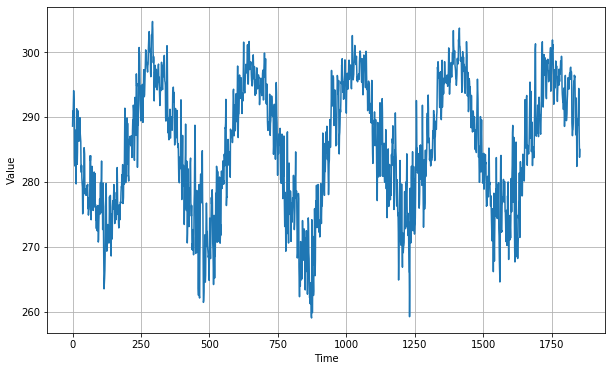

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Load data    
df = pd.read_csv('temperature.csv')

# Measure average daily temperature
df['datetime'] = df['datetime'].map(lambda x: str(x)[:10])
df = df.groupby('datetime').mean()
df.dropna(subset=['New York'], inplace=True)

time = np.arange(0, len(df['New York']))
series = df['New York'].values

# Plotting the time series data
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, let's split it to start forecasting

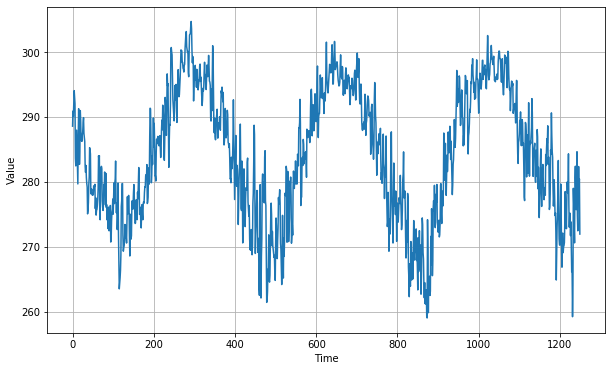

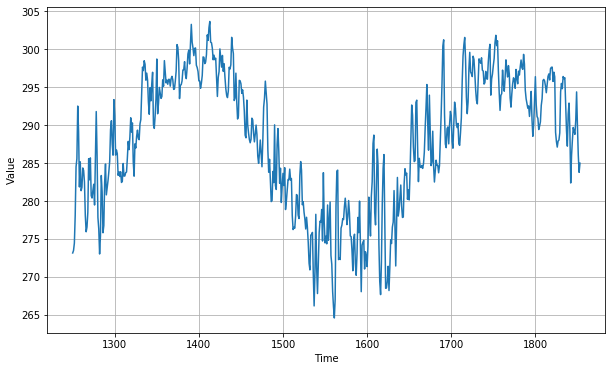

In [3]:
split_time = 1250
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Training data figure
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

# Validation data figure
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()


Now let's try moving average to do some predictions!

In [4]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

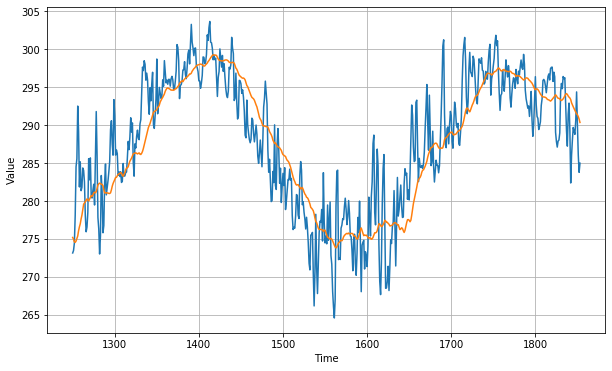

In [5]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [6]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

20.19731923351073
3.4842351516565726


It's worse than naive forecast! The moving average does not anticipate trend or seasonality,so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.

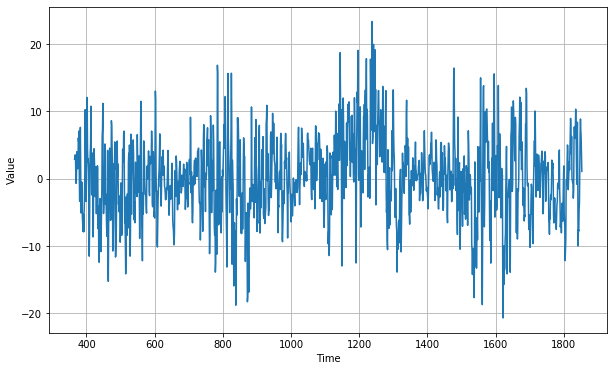

In [7]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

The trend and seasonality seem to be gone, so now we can use the moving average:

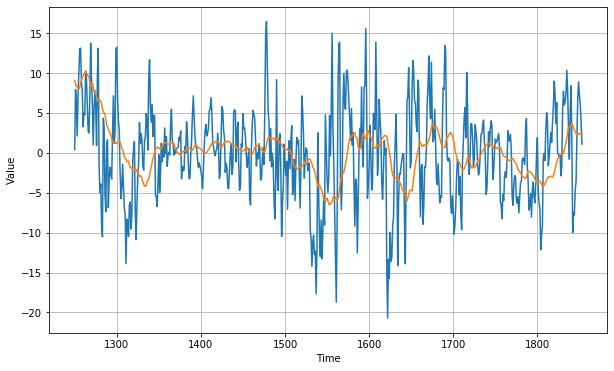

In [8]:
diff_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 365 - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Let's bring back the trend and seasonality by adding the past values from t – 365:

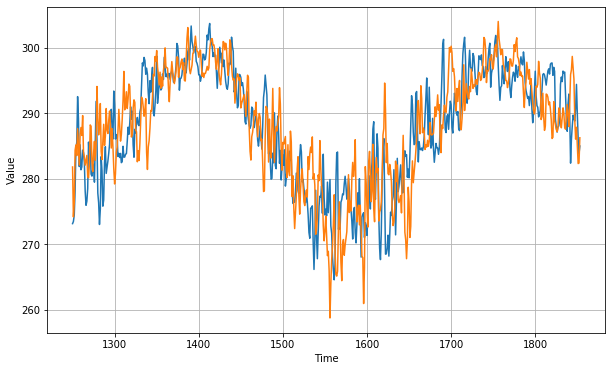

In [9]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

Let's use a moving averaging on past values to remove some of the noise:


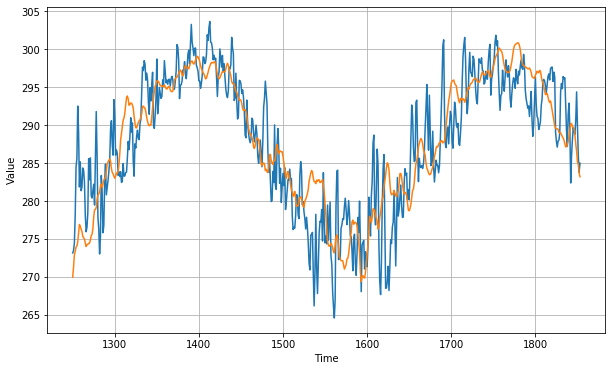

In [10]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10)
+ diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [11]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

24.08945481714042
3.7913654724660826


Define the dataset to start creating the deep learning model

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [13]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1250

Construct deep neural network with 3 layers of 10, 10, and 1 neurons. Each layer is activated by "relu" function. Then compile the model with the "mean squared error" and "stochastic gradient descent" optimizar. We'll fit the model over 100 epochs.

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-9, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

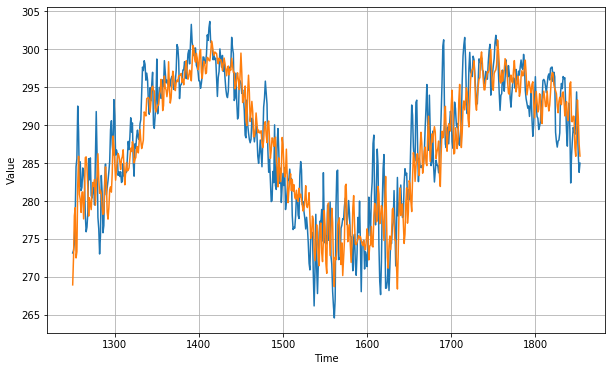

In [15]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

Now, let's calculate the mean absolute error.

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.2574399

Now let's try to improve the DNN, but how?!

Wouldn't it be nice if we could pick the optimal learning rate instead of the one that we chose? We'll use **callbacks** to do so!

In [18]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-9 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-9, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-09, 1e-05, 0, 300]

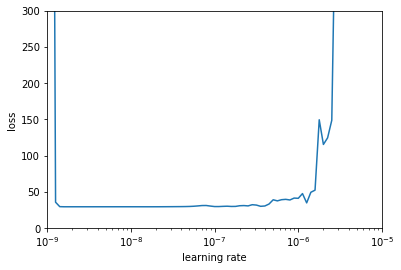

In [19]:
lrs = 1e-9 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.axis([1e-9, 1e-5, 0, 300])

Now let's try with the lowest point in the curve where it is still stable and see how the loss function reduces over each epoch.

In [20]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=1500, verbose=0)

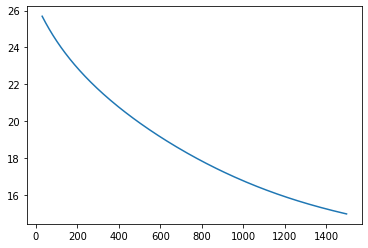

In [21]:
loss = history.history['loss']
epochs = range(30, len(loss))
plot_loss = loss[30:]
plt.plot(epochs, plot_loss)
plt.show()

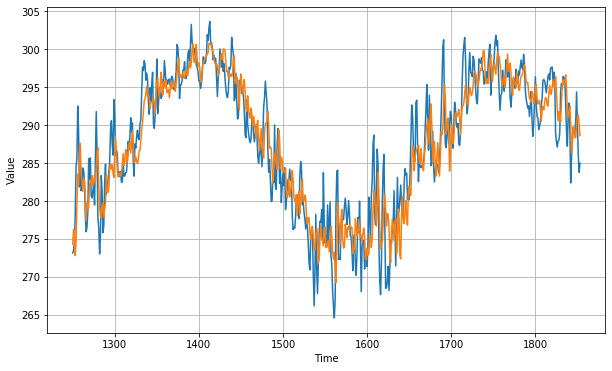

In [22]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.78056

As you can see, we could improve the prediction of time series data by tuning the hyper parameters of our model.

Using a simple DNN we improved our results nicely. However, there is no sequencing taken into account. In time series the values that are immediately before a value are more likely to impact it than those further in the past. Therefore, for more improvemenT we can take sequencing into account with methods such as Recurrent Neural Networks (RNN)